In [65]:
import numpy as np
import pandas as pd
from random import sample

In [ ]:
def move_agents(SuSca, Agents): # N_alive, V, S, M, x, y
    """
    Function to move the agents on the sugarscape.
    Implements one round where all the agents move once.
    
    Parameters
    ==========
    SuSca : Lattice representing the Sugarscape. 
    N_alive : Number of alive agents.
    V : Vision. 1-d numpy array.
    S : Sugar. 1-d numpy array.
    M : Metabolism. 1-d numpy array.
    x : x-position on the lattice of the agents. 1-d numpy array.
    y : y-position on the lattice of the agents. 1-d numpy array.
    """
    N_alive = Agents["Alive?"].sum() #

    SuSca_y, SuSca_x = SuSca.shape
    
    nSuSca = SuSca.copy()
    # print(nSuSca)
    # nx = x.copy()
    # ny = y.copy()
    # nS = S.copy()

    New_Agents = Agents.copy() #

    Alive_indices = np.where(Agents["Alive?"]==True)[0]
    Alive_x = New_Agents["X position"][Alive_indices]
    Alive_y = New_Agents["X position"][Alive_indices]
    

    # print(len(Alive_indices))
    
    # Define the order of the agents in this round.   
    order = np.random.permutation(Alive_indices)
    # print("Order: ", order)
    
    # For each agent: move it in the range of the vision.
    
    for i, na in enumerate(Alive_indices):
        ia = order[i]
        
        # Agent current position.
        # xa = nx[ia]
        # ya = ny[ia]
        # ma = M[ia]  # Metabolic rate.
        # va = V[ia]  # Vision.
        # sa = nS[ia]  # Available sugar/energy amount.
        xa = New_Agents["X position"][ia]
        ya = New_Agents["Y position"][ia]
        ma = New_Agents["Metabolic Rate"][ia]  # Metabolic rate.
        va = New_Agents["Vision"][ia]  # Vision.
        sa = New_Agents["Sugar Level"][ia]  # Available sugar/energy amount.
        
        # print(va)
        # print(xa)
        # Cells within the range of the agent.
        rx = np.zeros(va * 4 + 1) + xa
        ry = np.zeros(va * 4 + 1) + ya

        # First position is the current agents
        rx[0] = xa
        ry[0] = ya

        # Covers all cardinal directions
        rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
        rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
        ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
        ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1

        # Wrapping around boundaries
        rx = rx.astype(int) % SuSca_x
        ry = ry.astype(int) % SuSca_y

        # print("rx", rx)
        # print("ry", ry)
        sugar = nSuSca[ry, rx]        
        max_sugar = np.amax(sugar)
        searching_new_pos = True
        sugar_level = int(max_sugar)

        # print("\n")
        # print(f"Agent: {ia}, pos: {int(xa),int(ya)}")
        # print(list(map(int, (nSuSca[ry, rx]))))
        # print(rx)
        # print(ry)
        # print("Max sugar", sugar_level)
        
        # Agent looks for the best available position.
        while searching_new_pos:
            # Search options for a certain sugar level.
            options = np.where(sugar == sugar_level)[0]
            
            
            # For each option, check whether position is already occupied.            
            io = 0
            place_found = False

            while (io < np.size(options)) and (not place_found):
                i = options[io]
                x_ref = rx[i] % SuSca_x
                y_ref = ry[i] % SuSca_y

                # Check if the position is available.
                a_ref = np.intersect1d(
                    np.where(New_Agents.iloc[Alive_indices, 0] == x_ref)[0],
                    np.where(New_Agents.iloc[Alive_indices, 1] == y_ref)[0])
                
                if np.size(a_ref) == 0:
                    # Position is available
                    New_Agents.iloc[ia, 0] = x_ref 
                    New_Agents.iloc[ia, 1] = y_ref
                    New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
                    nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
                    place_found = True
                else:
                    # Check whether this is the current position.
                    if (x_ref == New_Agents["X position"][ia]) and (y_ref == New_Agents["Y position"][ia]):
                        New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
                        nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
                        place_found = True
                    else:
                        # The position is occupied by someone else.
                        io += 1
            
            # If we are here, we either have found a place or 
            # exausted the possibilities for this sugar_level
            
            if not place_found:
                if sugar_level > 0:
                    sugar_level -= 1
                else:
                    # The agent stays where it is.                    
                    New_Agents.iloc[ia, 4] += nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]]  # Agent takes the sugar.
                    nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] = 0
                    searching_new_pos = False
            else: 
                # A place has been found for the agent.
                searching_new_pos = False
        # print(nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] )
            
        # print("New pos: ", x_ref,y_ref)
            
        
    
    # All agents have moved.
    
    # Now pay the metabolic price.
    New_Agents.iloc[Alive_indices, 4] = New_Agents.iloc[Alive_indices, 4] - New_Agents.iloc[Alive_indices, 2]
    
    # Now check which agents are still alive.
    # still_alive = np.where(nS > 0)[0]
    
    # N_still_alive = np.size(still_alive)
    # V_alive = V[still_alive]
    # S_alive = nS[still_alive]
    # M_alive = M[still_alive]
    # x_alive = nx[still_alive]
    # y_alive = ny[still_alive]

    not_alive = np.where(New_Agents["Sugar Level"] <= 0)[0]
    New_Agents.iloc[not_alive, 5] = False
        
    return nSuSca, New_Agents #N_still_alive, V_alive, S_alive, M_alive, x_alive, y_alive




Initialize the sugarscape in the "classical" way.

In [67]:
def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    SuSca = np.zeros([N, N])
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    for k in range(np.size(x_centers)):
        d = np.sqrt((X - x_centers[k]) ** 2 +
                    (Y - y_centers[k]) ** 2)
        for i in range(np.size(s_levels)):
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca


Function to convert a 2 dimensional numpy array into a RGB image.

In [68]:
def convert2RBG(SuSca, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    game_outcome = SuSca.copy()
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Check whether the initialization works.

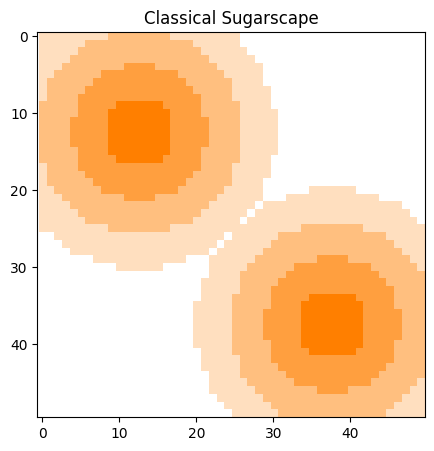

In [69]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.

SuSca = initialize_sugarscape(N)

# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [70]:


# N = 50  # Size of the sugarscape with the agents.
# A = 400  # Number of agents on the sugarscape.

# # Initial values. Chosen from the following flat distributions.
# possible_m = np.arange(4) + 1  # Metabolic rate.
# possible_v = np.arange(6) + 1  # Vision.
# possible_s = np.arange(21) + 5  # Sugar.

# # Agents initialized. 
# M = np.random.randint(np.size(possible_m), size=A) + 1
# V = np.random.randint(np.size(possible_v), size=A) + 1
# S = np.random.randint(np.size(possible_s), size=A) + 5

# # Define agents position. 
# L = np.array(sample(range(N * N), A)).astype(int) 
# x = L % N
# y = ((L - x) / N).astype(int) 
# # This way each agent occupy a different cell.

# SuSca = initialize_sugarscape(N)

In [71]:
# import time 
# from tkinter import Tk
# from tkinter import Canvas

# r0 = 0.25
# N_skip = 1

# # Visualize status every N_skip steps. 
# window_size = 600

# cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

# tk = Tk()
# tk.geometry(f'{window_size + 20}x{window_size + 20}')
# tk.configure(background='#000000')

# canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
# tk.attributes('-topmost', 0)
# canvas.place(x=10, y=10, height=window_size, width=window_size)

# step = 0

# def stop_loop(event):
#     global running
#     running = False
# tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
# running = True  # Flag to control the loop.
# while running:

#     nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

#     # Update animation frame.
#     if step % N_skip == 0:        
#         canvas.delete('all')
#         SU_cells = []
#         for i in range(N):
#             for j in range(N):
#                 cell_color = cell_color_list[int(nSuSca[i, j])]
#                 #
#                 SU_cells.append(
#                     canvas.create_rectangle(
#                         i / N * window_size, 
#                         j / N * window_size,
#                         (i + 1) / N * window_size,
#                         (j + 1) / N * window_size, 
#                         outline='', 
#                         fill=cell_color,
#                     )
#                 )
#         Agents_circ = []
#         for i in range(nA):
#             Agents_circ.append(
#                 canvas.create_oval(
#                     (nx[i] + 0.5 - r0) / N * window_size, 
#                     (ny[i] + 0.5 - r0) / N * window_size,
#                     (nx[i] + 0.5 + r0) / N * window_size,
#                     (ny[i] + 0.5 + r0) / N * window_size, 
#                     outline='', 
#                     fill='#000000',
#                 )
#             )
        
#         tk.title(f'Iteration {step}')
#         tk.update_idletasks()
#         tk.update()
#         time.sleep(0.1)  # Increase to slow down the simulation.

#     A = nA
#     V = nV.copy()
#     S = nS.copy()
#     M = nM.copy()
#     x = nx.copy()
#     y = ny.copy()
#     step += 1
    
# tk.update_idletasks()
# tk.update()
# tk.mainloop()  # Release animation handle (close window to finish).

Now let's try without animation.

In [72]:
N = 50 #50  # Size of the sugarscape with the agents.
A = 400 #400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
# possible_m = np.arange(4) + 1  # Metabolic rate.
# possible_v = np.arange(6) + 1  # Vision.
# possible_s = np.arange(21) + 5  # Sugar.

possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
# M = np.random.randint(np.size(possible_m), size=A) + 1
# V = np.random.randint(np.size(possible_v), size=A) + 1
# S = np.random.randint(np.size(possible_s), size=A) + 5

# M0 = M.copy()
# S0 = S.copy()
# V0 = V.copy()

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

# New Initialize agents
data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolic Rate": np.random.randint(np.size(possible_m), size=A)+1,
    "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
    "Sugar Level": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}

# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolic Rate": 1,
#     "Vision": 4,
#     "Sugar Level": 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

Agents = pd.DataFrame(data)



Agents0 = Agents.copy()



SuSca = initialize_sugarscape(N)


[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


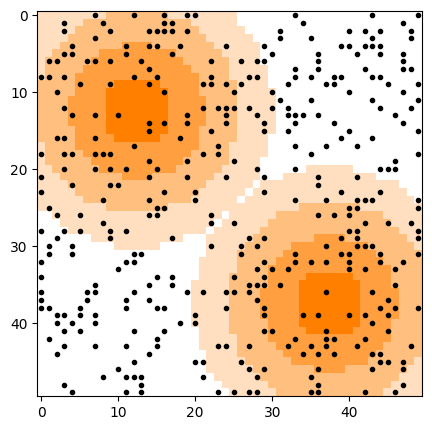

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          26               3       3           22    True
1            35          18               2       4            7    True
2            14          15               2       2           25    True
3            44          38               3       5            7    True
4            29          39               2       2           11    True
..          ...         ...             ...     ...          ...     ...
395          28           8               3       4            5    True
396          37          30               3       3           20    True
397          12           0               2       5            6    True
398          39          29               2       3           23    True
399          11          43               2       1           11    True

[400 rows x 6 columns]


In [73]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

print(Agents)

In [74]:
print(SuSca[4, 3])

2.0


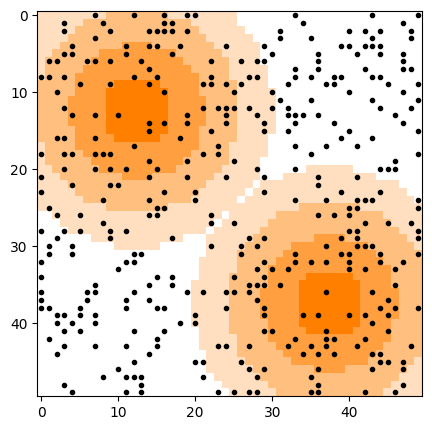

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          26               3       3           22    True
1            35          18               2       4            7    True
2            14          15               2       2           25    True
3            44          38               3       5            7    True
4            29          39               2       2           11    True
..          ...         ...             ...     ...          ...     ...
395          28           8               3       4            5    True
396          37          30               3       3           20    True
397          12           0               2       5            6    True
398          39          29               2       3           23    True
399          11          43               2       1           11    True

[400 rows x 6 columns]


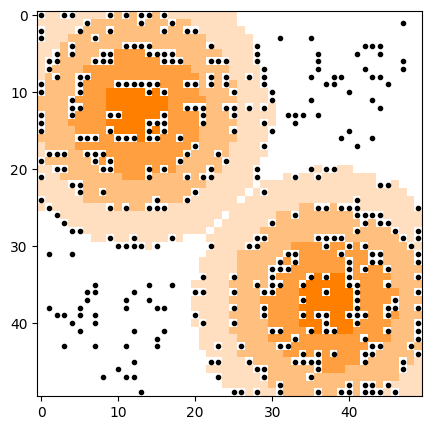

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            2    True
2            14          15               2       2           35    True
3            41          38               3       5           12    True
4            29          39               2       2           16    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           11    True
398          39          29               2       3           28    True
399          11          43               2       1            1    True

[400 rows x 6 columns]


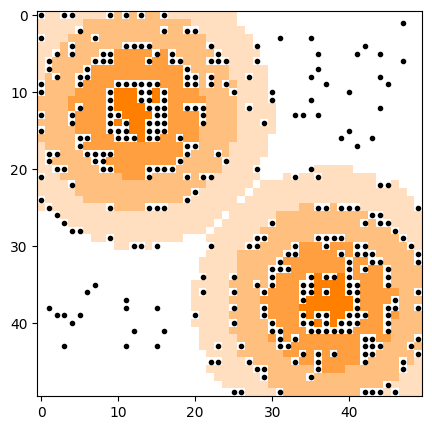

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           45    True
3            41          38               3       5           17    True
4            29          39               2       2           21    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           16    True
398          39          29               2       3           33    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


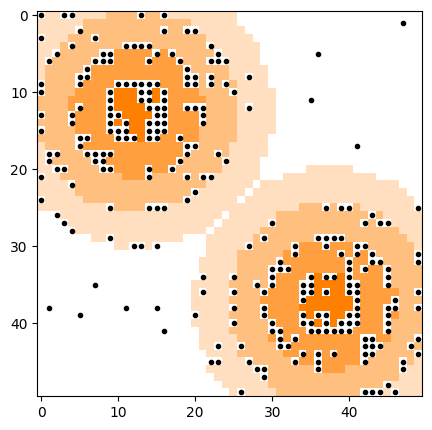

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           55    True
3            41          38               3       5           22    True
4            29          39               2       2           26    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           21    True
398          39          29               2       3           38    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


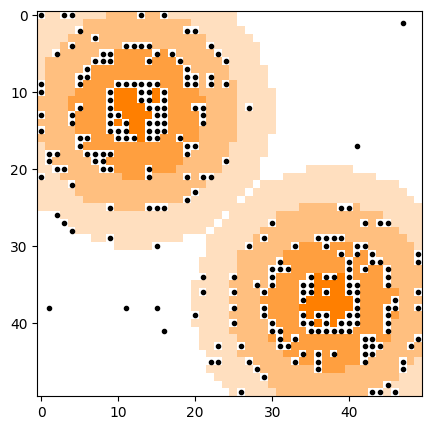

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           65    True
3            41          38               3       5           27    True
4            29          39               2       2           31    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           26    True
398          39          29               2       3           43    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


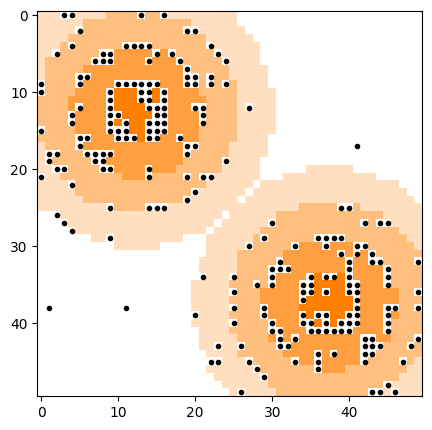

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           75    True
3            41          38               3       5           32    True
4            29          39               2       2           36    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           31    True
398          39          29               2       3           48    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


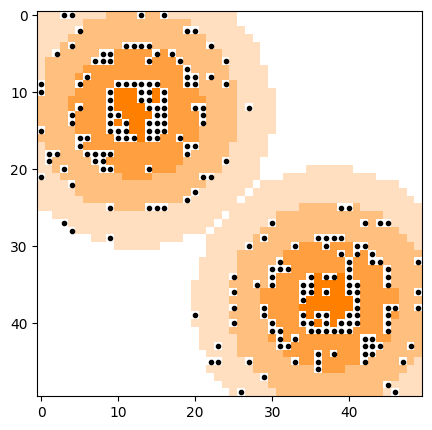

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           85    True
3            41          38               3       5           37    True
4            29          39               2       2           41    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           36    True
398          39          29               2       3           53    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


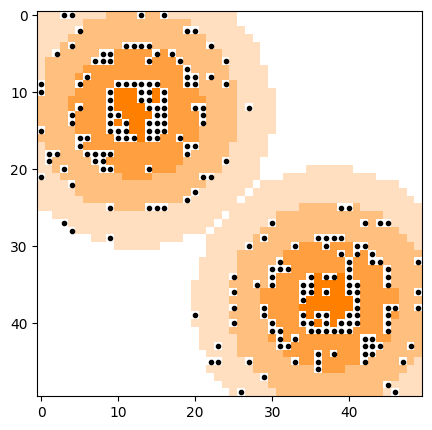

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2           95    True
3            41          38               3       5           42    True
4            29          39               2       2           46    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           41    True
398          39          29               2       3           58    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


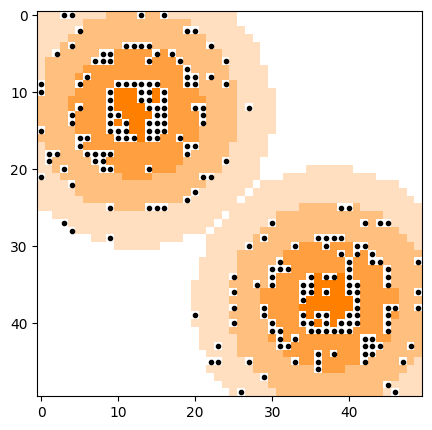

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          105    True
3            41          38               3       5           47    True
4            29          39               2       2           51    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           46    True
398          39          29               2       3           63    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


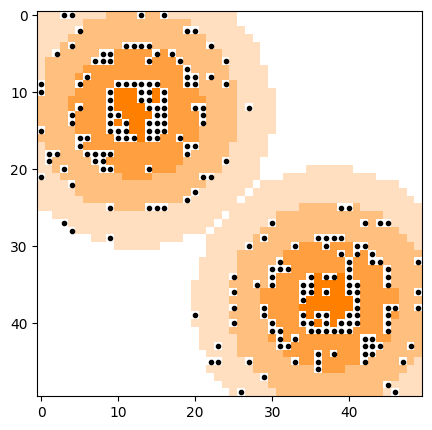

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          115    True
3            41          38               3       5           52    True
4            29          39               2       2           56    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           51    True
398          39          29               2       3           68    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


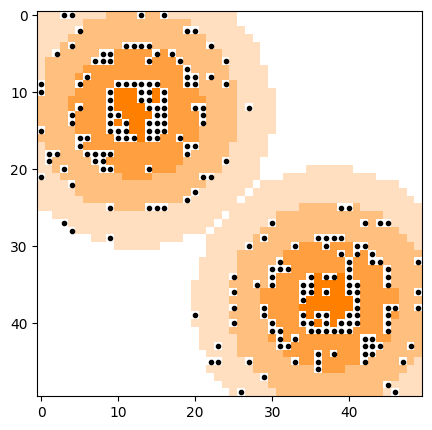

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          125    True
3            41          38               3       5           57    True
4            29          39               2       2           61    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           56    True
398          39          29               2       3           73    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


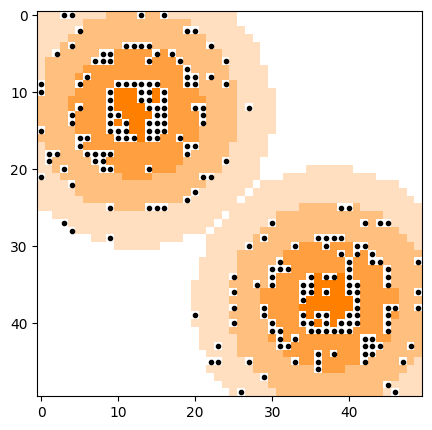

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          135    True
3            41          38               3       5           62    True
4            29          39               2       2           66    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           61    True
398          39          29               2       3           78    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


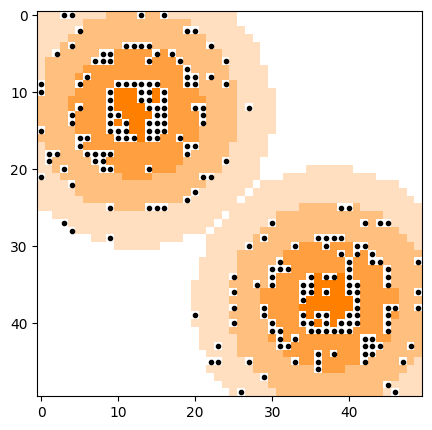

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          145    True
3            41          38               3       5           67    True
4            29          39               2       2           71    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           66    True
398          39          29               2       3           83    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


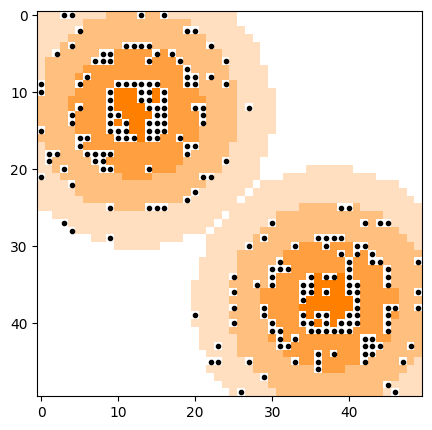

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          155    True
3            41          38               3       5           72    True
4            29          39               2       2           76    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           71    True
398          39          29               2       3           88    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


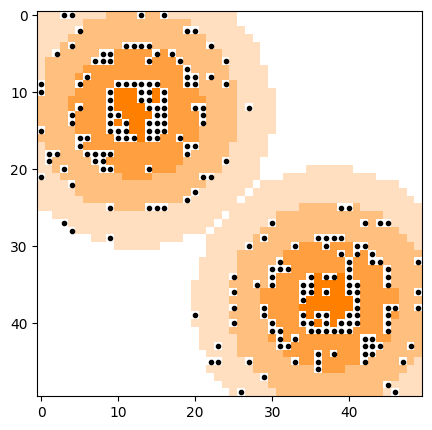

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          165    True
3            41          38               3       5           77    True
4            29          39               2       2           81    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           76    True
398          39          29               2       3           93    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


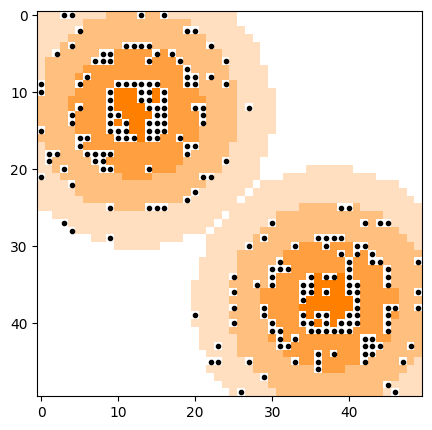

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          175    True
3            41          38               3       5           82    True
4            29          39               2       2           86    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           81    True
398          39          29               2       3           98    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


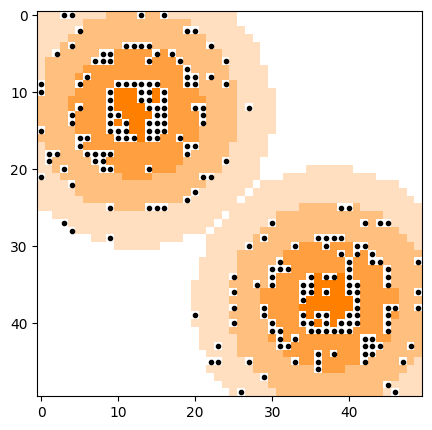

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          185    True
3            41          38               3       5           87    True
4            29          39               2       2           91    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           86    True
398          39          29               2       3          103    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


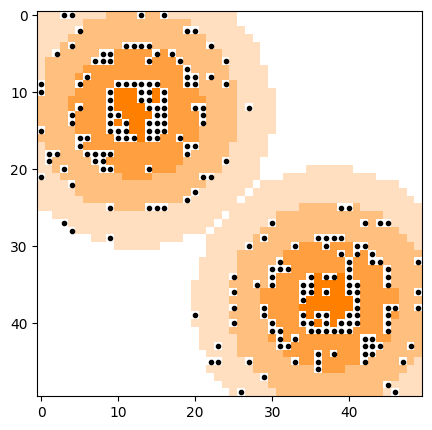

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          195    True
3            41          38               3       5           92    True
4            29          39               2       2           96    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           91    True
398          39          29               2       3          108    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


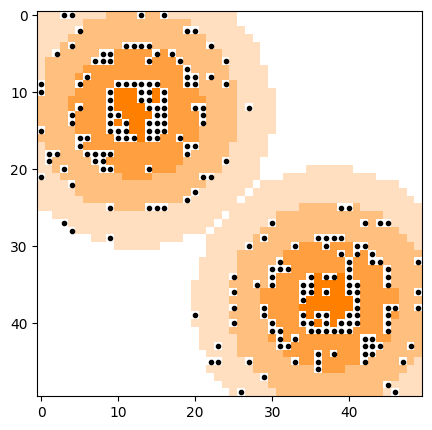

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          205    True
3            41          38               3       5           97    True
4            29          39               2       2          101    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5           96    True
398          39          29               2       3          113    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


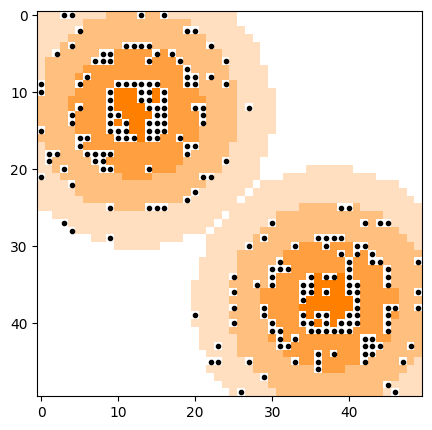

     X position  Y position  Metabolic Rate  Vision  Sugar Level  Alive?
0            38          29               3       3           22    True
1            35          20               2       4            0   False
2            14          15               2       2          215    True
3            41          38               3       5          102    True
4            29          39               2       2          106    True
..          ...         ...             ...     ...          ...     ...
395          20           8               3       4            4    True
396          37          30               3       3           20    True
397          12           4               2       5          101    True
398          39          29               2       3          118    True
399          11          43               2       1           -1   False

[400 rows x 6 columns]


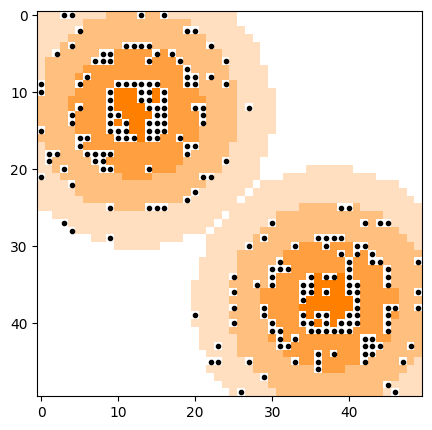

In [75]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 100#1001
N_skip = 5 #200
step = 0

N_alive_agents = np.zeros(MAX_STEP)

running = True  # Flag to control the loop.
while running:
    
    N_alive_agents[step] = Agents["Alive?"].sum()
    Alive_agents = np.where(Agents["Alive?"]==True)[0]

    nSuSca, New_Agents= move_agents(SuSca, Agents) # A, V, S, M, x, y   nA, nV, nS, nM, nx, ny
    # print(nSuSca)
    if step % N_skip == 0:  
        print(Agents) 
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(New_Agents["X position"][Alive_agents], New_Agents["Y position"][Alive_agents], '.', color='k')
        plt.show()

    
    # A = nA
    # V = nV.copy()
    # S = nS.copy()
    # M = nM.copy()
    # x = nx.copy()
    # y = ny.copy()

    # SuSca = nSuSca.copy()

    Agents = New_Agents.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
# M1 = M.copy()
# S1 = S.copy()
# V1 = V.copy()

Agents1 = Agents.copy()



Compare histograms:

In [76]:
print(A)

400


#### Metabolism

In [77]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





NameError: name 'M0' is not defined

#### Vision

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


